# Predict constumer default on their loan

<b>Andreea Nistor - Data Scientist candidate</b>

<b>&#x1F4C5; January 12th 2024</b>

## 	&#x26F3; 1. Bussines understanding

### Project overview
Develop a risk model to measure the probability of a customer ceasing repayment of their balance. Your task is to fit a classifier to predict which customers will be unable to pay their balance within the next 12 months, given some information at the time of the application.

### Output
- A `.ipynb file` (preferred) or a `.py file` (or a combination).
- Model file (e.g., in pickle format) and an inference script.
- Relevant visualizations of your analysis, either as part of the notebook or a separate file (e.g., PowerPoint). - You might need to explain your approach and findings with the help of these visualizations in a follow-up session.

### Evaluation
You will be evaluated based on:

- Coding standards
- Chosen approach
- Model performance

If the features were not anonymized, what extra checks would you perform to further evaluate the validity of your model? Feel free to share thoughts on other approaches that might be useful and what additional data might enhance your current approach.

Model performance will be evaluated using the test set and a holdout set. The probability output will be used to decide if an application is accepted or rejected.

### Questions & Answers 
(what are the questions you want to ask them)
1. how do you plan to use ? Treat those with higher probability ? what about the ones with low probability - do you intend any treatment for them? is a simple score enough or do you need a calibrated probability (https://scikit-learn.org/1.5/modules/calibration.html) - While a score alone is sufficient, it is beneficial to explain the advantages of a well-calibrated probability and its potential uses.

2. What infrastructure are you considering for deploying this model? Do you envision using a smaller CPU machine, or would it be worth deploying on a larger machine with a GPU for deep learning in case deep learning proves to be better than a traditional machine learning approach? - Do not worry about infrastructure for now. Keep in mind that this is a high-materiality model, meaning it will have a financial impact on customers.

3. Do you have an estimate of the costs associated with misclassifying someone as likely to cease paåyments versus not likely to cease payments? - You do not need to make assumptions about the costs associated with a defaulted account. This is a unit-rate model. However, provide notes on how you would handle it if you had the loss associated with a defaulted account.

4. Which business metric or KPI will be most impacted by this prediction? - Document which KPIs are impacted by a model applied during a credit card application process and identify the most important KPI for a credit card company.




## 	&#x26F3; Exploratory data analysis


Download <i>Default of Credit Card Clients Dataset</i> from Kaggle

In [51]:
# # Download the dataset
# !kaggle datasets download -d uciml/default-of-credit-card-clients-dataset
# # Create the ./data directory if it doesn't exist
# !mkdir -p ./data

# # Unzip the dataset into the ./data folder
# !unzip default-of-credit-card-clients-dataset.zip -d ./data

# # Delete the zip file
# !rm default-of-credit-card-clients-dataset.zip

Install the necessary libraries

In [52]:
# !pip install --quiet pandas scikit-optimize xgboost shap pywaffle graphviz seaborn

In [57]:
import pandas as pd # This library is used for data understanding and preparation
import os #To handle paths in a way that is portable
from sklearn.metrics import confusion_matrix #Confusion matrix for model evaluation
from sklearn.metrics import classification_report, roc_curve, auc #For machine learning metrics
import xgboost as xgb #To train an xgboost classifier
import pickle #To save machine-learning models
from skopt import BayesSearchCV #For hyperparameter optimization
from skopt.space import Integer, Real #For the priories in hyperparameter optimization
import matplotlib.pyplot as plt #To make some plots
import numpy as np #To process some vectors
import shap #For explanability
from pywaffle import Waffle #This library is used for waffle plots
from graphviz import Digraph #To display the outline of the notebook
from IPython.display import Image #To display estimators of the XGBoost model
from typing import Union #To type the output of the function
from pandas import DataFrame #To type the output of the function

In [55]:
# Company's brand colours
dark_blue = "#05becd"
light_blue = "#1fe0df"
black = "black"
dark_gray = "#1d1d1f"
gray = "gray"
light_gray = "#d3d3d3"
white = "white"

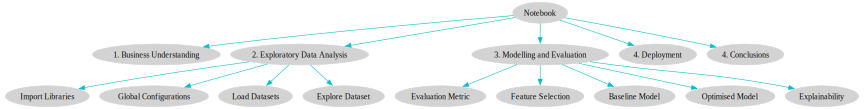

In [56]:
# Initialize a new directed graph
dot = Digraph(comment='Structure of the document')

# Set graph attributes
dot.attr(bgcolor=white)     # Set background color to black
dot.attr(size='12, 10')      # Set size of the graph
dot.attr(rankdir='TB')      # Top to bottom layout (default is TB)

# Set default node and edge attributes
dot.attr('node', style='filled', fillcolor=light_gray, fontcolor=black, color=light_gray)  # Dark blue text, light blue outline
dot.attr('edge', color=dark_blue)  # Light blue arrows

# Define the tree structure
dot.node('A', 'Notebook')                           # Root node
dot.node('B', '1. Business Understanding')          # First child of root
dot.node('C', '2. Exploratory Data Analysis')       # Second child of root
dot.node('D', '3. Modelling and Evaluation')        # Third child of root
dot.node('E', '4. Deployment')                      # Fourth child of root
dot.node('F', '4. Conclusions')                     # Fifth child of root

dot.node('C2', 'Import Libraries')                  # Child of Son 1
dot.node('C3', 'Global Configurations')             # Child of Son 1
dot.node('C4', 'Load Datasets')                     # Child of Son 1
dot.node('C5', 'Explore Dataset')                   # Child of Son 1

dot.node('D1', 'Evaluation Metric')                 # Child of Son 2
dot.node('D2', 'Feature Selection')                 # Child of Son 2
dot.node('D3', 'Baseline Model')                    # Child of Son 2
dot.node('D4', 'Optimised Model')                   # Child of Son 2
dot.node('D5', 'Explainability')                    # Child of Son 2


# Define edges between nodes to create hierarchy
dot.edge('A', 'B')              # Father -> Son
dot.edge('A', 'C')              # Father -> Son
dot.edge('A', 'D')              # Father -> Son
dot.edge('A', 'E')              # Father -> Son
dot.edge('A', 'F')              # Father -> Son

dot.edge('C', 'C2')              # Son -> Grandson
dot.edge('C', 'C3')              # Son -> Grandson
dot.edge('C', 'C4')              # Son -> Grandson
dot.edge('C', 'C5')              # Son -> Grandson

dot.edge('D', 'D1')              # Son -> Grandson
dot.edge('D', 'D2')              # Son -> Grandson
dot.edge('D', 'D3')              # Son -> Grandson
dot.edge('D', 'D4')              # Son -> Grandson
dot.edge('D', 'D5')              # Son -> Grandson


# Render and display the tree
display(dot)

Helper functions

In [ ]:
def plot_roc_curve(
    y_true: Union[list, np.ndarray], 
    y_pred_prob: Union[list, np.ndarray], 
    dataset: str
) -> None:
    """
    Plots the Receiver Operating Characteristic (ROC) curve for a given dataset.

    Args:
        y_true (Union[list, np.ndarray]): True binary labels.
        y_pred_prob (Union[list, np.ndarray]): Predicted probabilities for the positive class.
        dataset (str): Name of the dataset to include in the plot title.

    Returns:
        None
    """
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) ' + dataset.capitalize())
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


def missing_values_summary(df: DataFrame) -> DataFrame:
    """
    Summarizes columns in a DataFrame with significant missing values.

    Args:
        df (DataFrame): The input DataFrame to analyze.

    Returns:
        DataFrame: A DataFrame containing the count and percentage of missing values 
                   for columns with more than 70% missing data, sorted by percentage 
                   in descending order.

    The returned DataFrame has the following structure:
        - `Missing Values`: Total number of missing values per column.
        - `Percentage`: Percentage of missing values per column.
    """
    # Count total missing values for each column
    missing_count = df.isnull().sum()

    # Calculate percentage of missing values for each column
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Create a DataFrame summarizing the missing data
    missing_summary = pd.DataFrame({
        'Missing Values': missing_count,
        'Percentage': missing_percentage
    })

    # Filter only columns with missing data and sort by the most missing
    missing_summary = missing_summary[missing_summary['Percentage'] > 70]
    missing_summary = missing_summary.sort_values(by='Percentage', ascending=False)

    return missing_summary


### Load dataset

In [58]:
path = 'data/UCI_Credit_Card.csv'
data = pd.read_csv(path)

### Explore dataset

In [59]:
data.info()

# no missing values
# all columns are numerical
# target variable is 'default.payment.next.month'
# 30,000 rows and 25 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

&#x2757; In this dataset, there are no missing values. However, if missing data were present, it would be important to either remove or impute the missing values, depending on the dataset characteristics. 

&#x2757; The dataset consists of both numeric and categorical columns, but as the categorical columns (SEX, EDUCATION, MARRIAGE) are already encoded as integers, no further encoding is required for these features. However, if there were non-numeric factors in the future, techniques like one-hot encoding or LabelEncoder can be used.

In [60]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


&#x2757;	 The dataset variables have different scales. If using a model sensitive to feature scaling, standardize the values for consistent performance.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming the dataset is in a DataFrame called df
# Exclude the 'ID' column
df_no_id = df.drop(columns=['ID'])

# Create a grid plot for all columns in the dataset (excluding 'ID')
num_columns = len(df_no_id.columns)
n_rows = (num_columns + 3) // 4  # To arrange in a grid with 4 columns

plt.figure(figsize=(16, 4 * n_rows))

# Loop through each column and plot its distribution
for i, column in enumerate(df_no_id.columns):
    plt.subplot(n_rows, 4, i + 1)
    sns.histplot(df_no_id[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()
